In [1]:
#!pip install prince

#Imports

In [2]:
#Imports
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.manifold import MDS

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


#Loading Data

In [3]:
#Importing data
data = pd.read_csv('monroe-county-crash-data2003-to-2015.csv',encoding='latin1')

In [4]:
#peaking at data
print(data.head())

   Master Record Number  Year  Month  Day Weekend?    Hour Collision Type  \
0             902363382  2015      1    5  Weekday     0.0          2-Car   
1             902364268  2015      1    6  Weekday  1500.0          2-Car   
2             902364412  2015      1    6  Weekend  2300.0          2-Car   
3             902364551  2015      1    7  Weekend   900.0          2-Car   
4             902364615  2015      1    7  Weekend  1100.0          2-Car   

          Injury Type                         Primary Factor  \
0   No injury/unknown  OTHER (DRIVER) - EXPLAIN IN NARRATIVE   
1   No injury/unknown                  FOLLOWING TOO CLOSELY   
2  Non-incapacitating              DISREGARD SIGNAL/REG SIGN   
3  Non-incapacitating          FAILURE TO YIELD RIGHT OF WAY   
4   No injury/unknown          FAILURE TO YIELD RIGHT OF WAY   

       Reported_Location   Latitude  Longitude  
0             1ST & FESS  39.159207 -86.525874  
1          2ND & COLLEGE  39.161440 -86.534848  
2  BA

In [5]:
#saving original version of data
original_data = data.copy()

#Preprocessing

###Dropping unnecessary columns and Rows with Null Values

In [6]:
#======================PREPROCESSING==================================

#1 drop Master Record Number colum. it serves no purpose in this case
data.drop('Master Record Number',axis = 1,inplace=True)
data.drop('Reported_Location',axis = 1,inplace=True)

data.columns

Index(['Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type',
       'Injury Type', 'Primary Factor', 'Latitude', 'Longitude'],
      dtype='object')

In [7]:
#3 dropping records with blank hours
data = data.dropna(subset=['Hour'])

In [8]:
#4 droping invalid latitude and longitude

print(len(data[(data.Latitude == 0) 
	|(data.Latitude == 1) 
	| (data.Longitude == 0)
	|(data.Longitude == 1)
	|(data.Longitude.isna()
	|(data.Latitude.isna()))]))

#print(len(data))

data = data.drop(data[(data.Latitude == 0) 
	|(data.Latitude == 1) 
	| (data.Longitude == 0)
	|(data.Longitude == 1)
	|(data.Longitude.isna()
	|(data.Latitude.isna()))].index)

4933


###Replacing Invalid Values with Correct Values

In [9]:
data['Latitude'][data['Latitude']<=9.133739] = 39.133739
data['Latitude'][data['Latitude']<=9.183292] = 39.183292

#Exploring Data

##Plotting

In [10]:
print(data)

       Year  Month  Day Weekend?    Hour Collision Type         Injury Type  \
0      2015      1    5  Weekday     0.0          2-Car   No injury/unknown   
1      2015      1    6  Weekday  1500.0          2-Car   No injury/unknown   
2      2015      1    6  Weekend  2300.0          2-Car  Non-incapacitating   
3      2015      1    7  Weekend   900.0          2-Car  Non-incapacitating   
4      2015      1    7  Weekend  1100.0          2-Car   No injury/unknown   
...     ...    ...  ...      ...     ...            ...                 ...   
53344  2003      4    7  Weekend  2000.0          1-Car   No injury/unknown   
53345  2003      5    7  Weekend  1500.0          1-Car  Non-incapacitating   
53346  2003     11    3  Weekday  2300.0          1-Car   No injury/unknown   
53347  2003     12    7  Weekend  1700.0          1-Car  Non-incapacitating   
53348  2003      6    7  Weekend   800.0          1-Car   No injury/unknown   

                              Primary Factor   Lati

###Dimensionality reduction

In [11]:
from sklearn import preprocessing
import prince

data_to_reduce = data

In [12]:
#Droping null values 
data_to_reduce.dropna(inplace= True)

In [13]:
#MCA multiple correspondence analysis 
mca = prince.FAMD(n_components = 9,
                 n_iter = 5,
                 copy = True,
                 check_input = True,
                 engine = 'auto',
                 random_state = 42)
mca.fit(data_to_reduce)

FAMD(check_input=True, copy=True, engine='auto', n_components=9, n_iter=5,
     random_state=42)

In [14]:
mca_components = mca.row_coordinates(data_to_reduce)
print(mca_components.head())

            0           1           2           3           4           5  \
0  578.054178  -13.145942  -36.311742 -100.310700  -77.280995 -211.374933   
1  585.497016  -37.018350    2.753747 -111.922591 -198.720904  197.651858   
2  263.503769  110.663648  346.169749  341.561811 -127.790578  -98.432201   
3  308.278477   92.334918  434.476992  353.871772  157.117814   11.171554   
4  463.025484  346.446175  217.173958   80.601706  222.592648   75.690528   

            6          7           8  
0  213.918228  -4.657161  -49.880344  
1   32.802074 -66.141863  -63.175159  
2  -71.697467 -53.787418  186.403080  
3   -8.257012   2.312459  -38.626064  
4   36.173727   7.947386  -19.137965  


In [15]:
#saving reference to reduced data 
reduced_data = mca_components

In [16]:
#contribution of each component to data
comp_percentages = pd.DataFrame(sorted(mca.explained_inertia_,reverse = True))
print(comp_percentages)

          0
0  0.504541
1  0.091939
2  0.079310
3  0.067392
4  0.044534
5  0.031570
6  0.026578
7  0.019865
8  0.015106


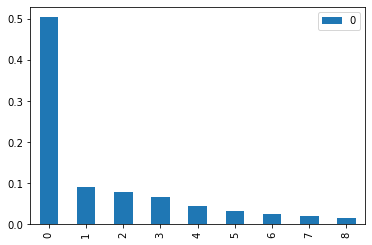

In [17]:
#plotting of components 
comp_percentages.plot(kind = 'bar')

######Initial Plotting

Since the firt component accounts for most of the data, we try an initial 1-D plot with just the first component. Already it hints at four clusters. The only class with four distint categories is the injury type class. This might be a clue as of what these groupings mean.

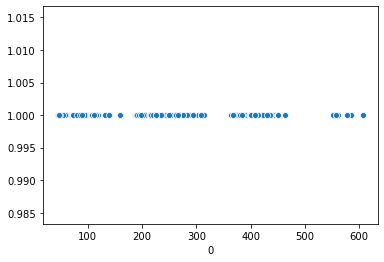

In [18]:
sns.scatterplot(mca_components[0],1)

######2D Plot

Again we try to plot in 2-D to see if there are any patterns embedded in the data. 

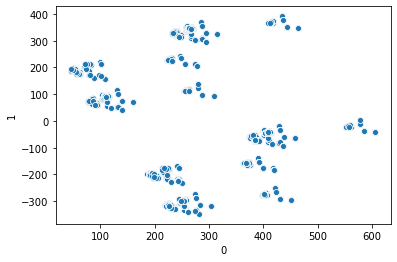

In [19]:
#initial plotting
x,y = mca_components[0],mca_components[1]
sns.scatterplot(x,y)

There seems to be more clusters. Let's test our hypothesis on if they have a correlation with the Injury Type categories. 

In [20]:
injury_types = data_to_reduce['Injury Type'].unique()
print(injury_types)

['No injury/unknown' 'Non-incapacitating' 'Incapacitating' 'Fatal']


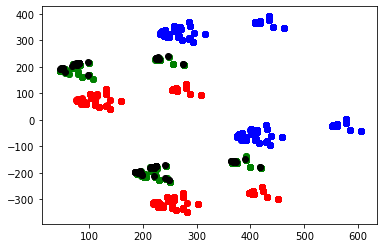

In [21]:
#testing clusters in plot
x1,y1 = x[data_to_reduce['Injury Type'] == injury_types[0]],y[data_to_reduce['Injury Type'] == injury_types[0]]
x2,y2 = x[data_to_reduce['Injury Type'] == injury_types[1]],y[data_to_reduce['Injury Type'] == injury_types[1]]
x3,y3 = x[data_to_reduce['Injury Type'] == injury_types[2]],y[data_to_reduce['Injury Type'] == injury_types[2]]
x4,y4 = x[data_to_reduce['Injury Type'] == injury_types[3]],y[data_to_reduce['Injury Type'] == injury_types[3]]

plt.scatter(x1,y1,color = 'blue')
plt.scatter(x2,y2,color = 'red')
plt.scatter(x3,y3,color ='green')
plt.scatter(x4,y4,color ='black')



######Clusters are more or less uniformed. Green and black are part of the same clusters, which can mean there should be three classes instead of 4. But further analysis is needed. 



####3D plot

In [22]:
from mpl_toolkits.mplot3d import Axes3D

In [23]:
#defining z
z = mca_components[2]

z1,z2,z3,z4 = z[data_to_reduce['Injury Type'] == injury_types[0]],z[data_to_reduce['Injury Type'] == injury_types[1]],z[data_to_reduce['Injury Type'] == injury_types[2]],z[data_to_reduce['Injury Type'] == injury_types[3]]


#####Different angles 

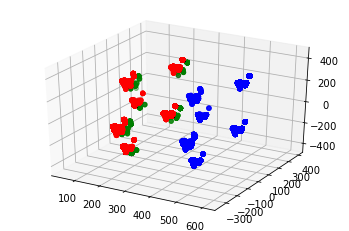

In [24]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1,y1,z1,c='blue')
ax.scatter(x2,y2,z2,c='red')
ax.scatter(x3,y3,z3,c='green')
ax.scatter(x4,y4,z4,c='black')

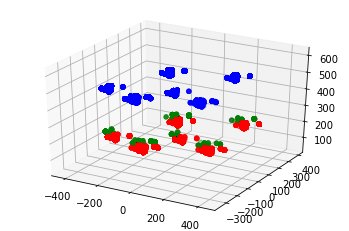

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(z1,y1,x1,c='blue')
ax.scatter(z2,y2,x2,c='red')
ax.scatter(z3,y3,x3,c='green')
ax.scatter(z4,y4,x4,c='black')

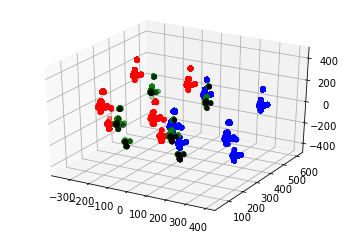

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y1,x1,z1,c='blue')
ax.scatter(y2,x2,z2,c='red')
ax.scatter(y3,x3,z3,c='green')
ax.scatter(y4,x4,z4,c='black')

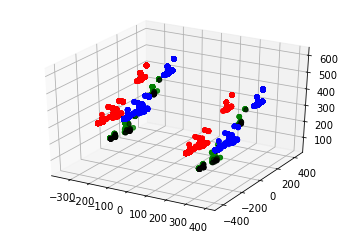

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y1,z1,x1,c='blue')
ax.scatter(y2,z2,x2,c='red')
ax.scatter(y3,z3,x3,c='green')
ax.scatter(y4,z4,x4,c='black')

######conclusion

We can see that at different angles we can seperate 3 different clusters into respective layers: Blue, Red, and Green+Black. In all the angles, green and black seem to be of the same cluster. Since the color code is based on the Injury Types, we can conclude that there are supposed to be three classes instead of four. 

###Over Sampling 

Let's check the distribution of data to see if what were infereing matches with what's actually there. 

In [28]:
#In order to plot the data we have to do dimensionality reduction 
#from sklearn import preprocessing
#import prince

#encoder = preprocessing.LabelEncoder()

#data_to_reduce = data
#data_to_reduce['Collision Type'] = encoder.fit_transform(original_data['Collision Type'].astype('str'))

#data_to_reduce['Primary Factor'] = encoder.fit_transform(original_data['Primary Factor'].astype('str'))

#data_to_reduce['Weekend?'] = encoder.fit_transform(original_data['Weekend?'].astype('str'))

#data_to_reduce.dropna(inplace = True)

In [29]:
#changing data type of text types 
#for i in ['Weekend?','Collision Type','Injury Type','Primary Factor']:
  #data_to_reduce[i] = data_to_reduce[i].astype('str')

In [30]:
####CHECK FOR OVER SAMPLING POSSIBILITY USING SMOTE
#Distribution of target class
from collections import Counter

dist = pd.DataFrame(Counter(data_to_reduce['Injury Type']).items())
dist = dist.set_index(dist[0]).drop(0,axis = 'columns')


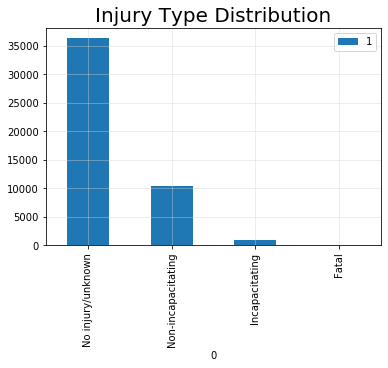

In [31]:
# dist plot *
plot = dist[[1]].plot(kind="bar");
plot.set_title("Injury Type Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

We can see that the representation of each Injury Type in the data is no where near even. We have to use some sort of sampling technique. 

In [32]:
#over sampling 
from imblearn.over_sampling import SMOTENC # uses KNN to generate new samples
from collections import Counter

features,labels = data.drop('Injury Type',axis = 'columns'), data['Injury Type']

#Synthetic Minority Over-Sampling Technique
#X_resampled, y_resampled = SMOTENC(categorical_features=[0,1,2,3,4,5,6,7]).fit_resample(features,labels)

Using TensorFlow backend.


In [33]:
#cols = data.drop('Injury Type',axis = 1).columns
#cols = np.append(cols,'Injury Type')

In [34]:
#res_data = pd.DataFrame(np.concatenate((X_resampled,y_resampled[:,np.newaxis]),axis = 1),columns = cols)
#res_data

######Saving to csv file*

In [35]:
#Saving res_data to csv so we don't have to regenerate it. 
#res_data.to_csv(r'drive/My Drive/Colab Notebooks/Data-Mining-Project/res_data.csv',index=False)

#####Loading data from saved csv file

In [36]:
res_data = pd.read_csv('res_data.csv')

In [37]:
# new distribution of target class

new_dist = Counter(res_data['Injury Type']).items() #shows that there are equal amounts in each class
new_dist = pd.DataFrame(new_dist,index=['No Injury/Unknown','Non-incapacitating','Incapcitatin','Fatal'])
print(new_dist)

                                     0      1
No Injury/Unknown    No injury/unknown  37289
Non-incapacitating  Non-incapacitating  37289
Incapcitatin            Incapacitating  37289
Fatal                            Fatal  37289


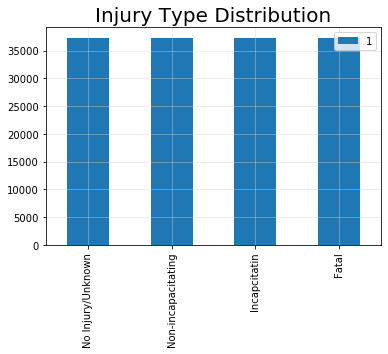

In [38]:
# new dist plot 
plot = new_dist[[1]].plot(kind="bar");
plot.set_title("Injury Type Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

###Reploting with resampled data

In [39]:
res_data.dropna(inplace=True)

In [40]:
res_reduced_data = mca.fit_transform(res_data)

In [41]:
#new percetages with resampled data
res_comp_percentages = pd.DataFrame(mca.explained_inertia_)

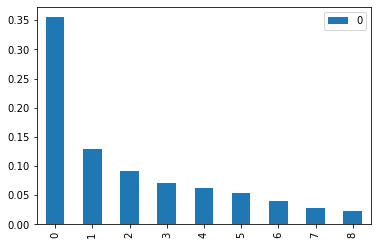

In [42]:
# new percentages plot with resampled data
pd.DataFrame(res_comp_percentages).plot(kind = 'bar')

####2D

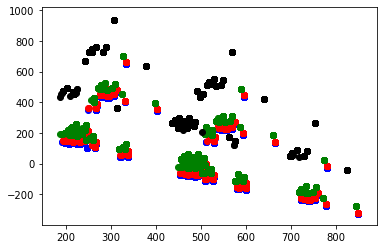

In [43]:
#testing clusters in plot

x,y,z = res_reduced_data[0],res_reduced_data[1],res_reduced_data[2]
x1,y1 = x[res_data['Injury Type'] == injury_types[0]],y[res_data['Injury Type'] == injury_types[0]]
x2,y2 = x[res_data['Injury Type'] == injury_types[1]],y[res_data['Injury Type'] == injury_types[1]]
x3,y3 = x[res_data['Injury Type'] == injury_types[2]],y[res_data['Injury Type'] == injury_types[2]]
x4,y4 = x[res_data['Injury Type'] == injury_types[3]],y[res_data['Injury Type'] == injury_types[3]]

plt.scatter(x1,y1,color = 'blue')
plt.scatter(x2,y2,color = 'red')
plt.scatter(x3,y3,color ='green')
plt.scatter(x4,y4,color ='black')


####3D

In [44]:
z1,z2,z3,z4 = z[res_data['Injury Type'] == injury_types[0]],z[res_data['Injury Type'] == injury_types[1]],z[res_data['Injury Type'] == injury_types[2]],z[res_data['Injury Type'] == injury_types[3]]


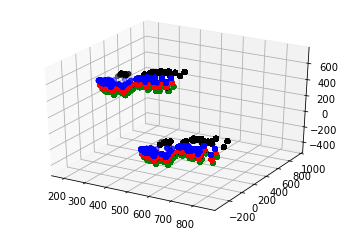

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1,y1,z1,c='blue')
ax.scatter(x2,y2,z2,c='red')
ax.scatter(x3,y3,z3,c='green')
ax.scatter(x4,y4,z4,c='black')

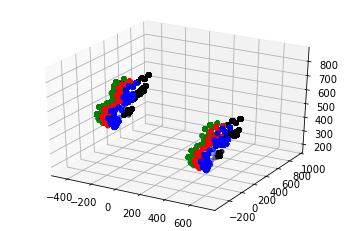

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(z1,y1,x1,c='blue')
ax.scatter(z2,y2,x2,c='red')
ax.scatter(z3,y3,x3,c='green')
ax.scatter(z4,y4,x4,c='black')

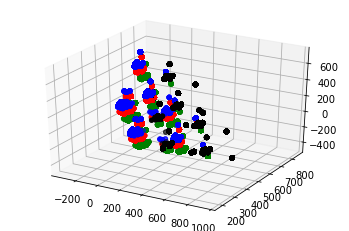

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y1,x1,z1,c='blue')
ax.scatter(y2,x2,z2,c='red')
ax.scatter(y3,x3,z3,c='green')
ax.scatter(y4,x4,z4,c='black')

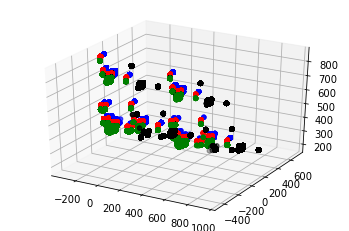

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y1,z1,x1,c='blue')
ax.scatter(y2,z2,x2,c='red')
ax.scatter(y3,z3,x3,c='green')
ax.scatter(y4,z4,x4,c='black')

It seems like the data is not as easy to seperate anymore, at least not by Injury types. However, we see that now it creates two distinct clusters. Let's explore the data further by running K-means on both the data before over-sampling and after over-sampling. 

###K-Means



In [49]:
#CLUSTERSING=================Components========================
from sklearn.cluster import KMeans
%config InlineBackend.figure_format='retina'

#####elbow plot function

In [50]:
#======================PCA ELBOW DEF==================
def elbow_plot(data,num_components,num_k = range(1,10)):
  k_num = num_k
  inertias = []
  for k in k_num:
      # Create a KMeans instance with k clusters: model
      model = KMeans(n_clusters=k)
    
      # Fit model to samples
      model.fit(data.iloc[:,:num_components])
    
      # Append the inertia to the list of inertias
      inertias.append(model.inertia_)
    
  plt.plot(k_num, inertias, '-o', color='black')
  plt.xlabel('number of clusters, k')
  plt.ylabel('inertia')
  plt.xticks(k_num)
  plt.show()

####Elbow for both plots

##### using 2 components

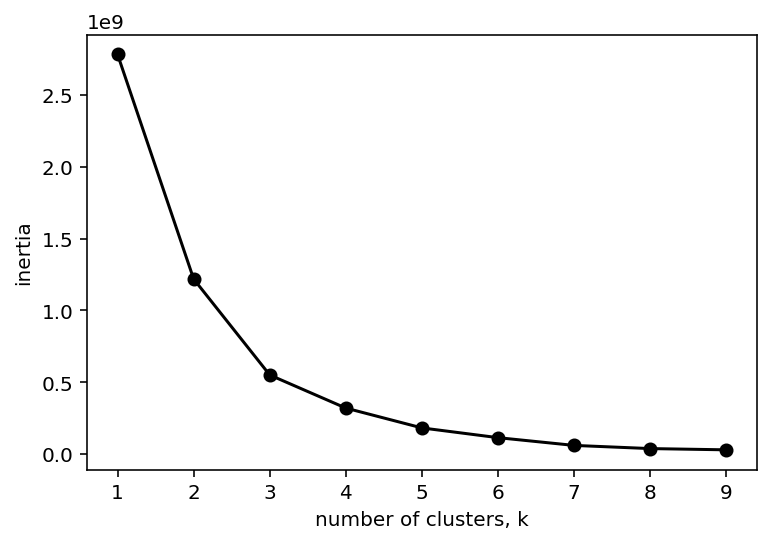

In [51]:
#elbow plot for for regular data
elbow_plot(reduced_data,2)

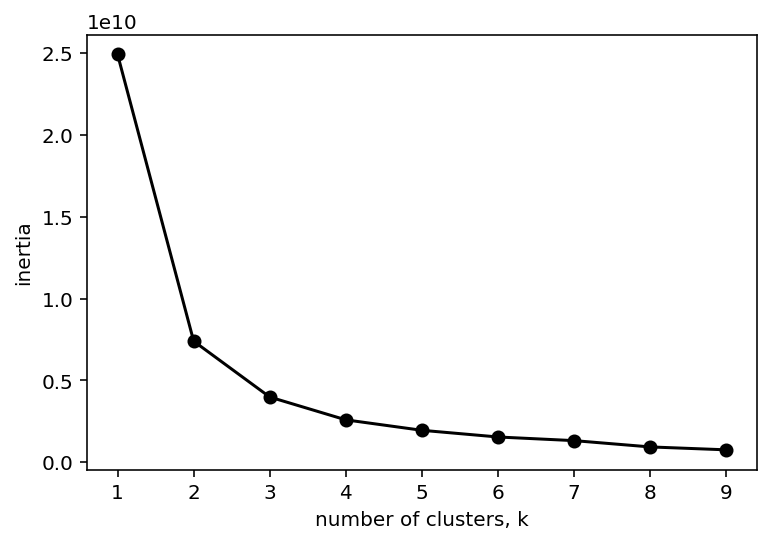

In [52]:
#elbow plot for resampled data
elbow_plot(res_reduced_data,2)

Here, we confirm what we visually inspected, that the resampled data clearly defines two clusters as being the ideal choice and the regular data is right between three or four. 

However, one thing to consider is how much of the data is being represented by the number of components in each case. 

In [53]:
print(comp_percentages[:2].sum())
print(res_comp_percentages[:2].sum())

0    0.59648
dtype: float64
0    0.484332
dtype: float64


We see that with the first two components, the data before over sampling holds close to 60% of the data, while the resampled data only holds about 48%. What if we chose the number of components in a way that made these percentages closer to being equal.

In [54]:
print(comp_percentages[:2].sum())
print(res_comp_percentages[:3].sum())

0    0.59648
dtype: float64
0    0.575105
dtype: float64


Here We see that when they are a lot closer when the resampled data uses 3 components while the original uses 2. 

#####using 3 components 

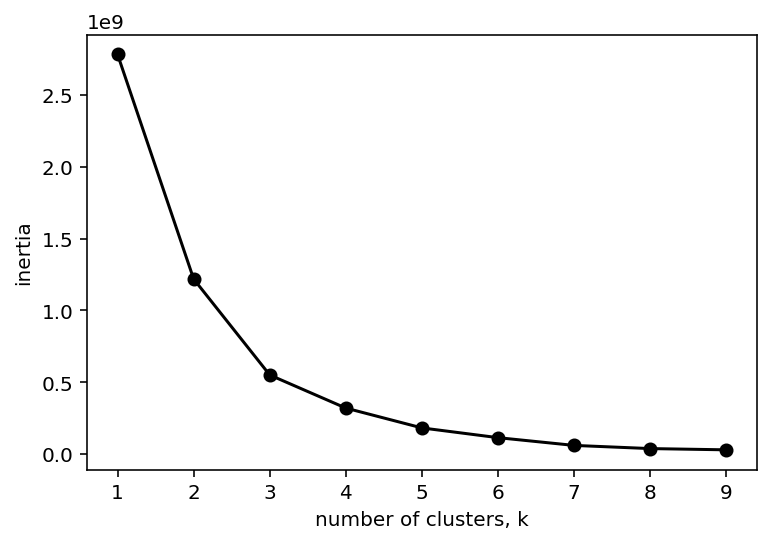

In [55]:
#elbow plot for for regular data
elbow_plot(reduced_data,2)

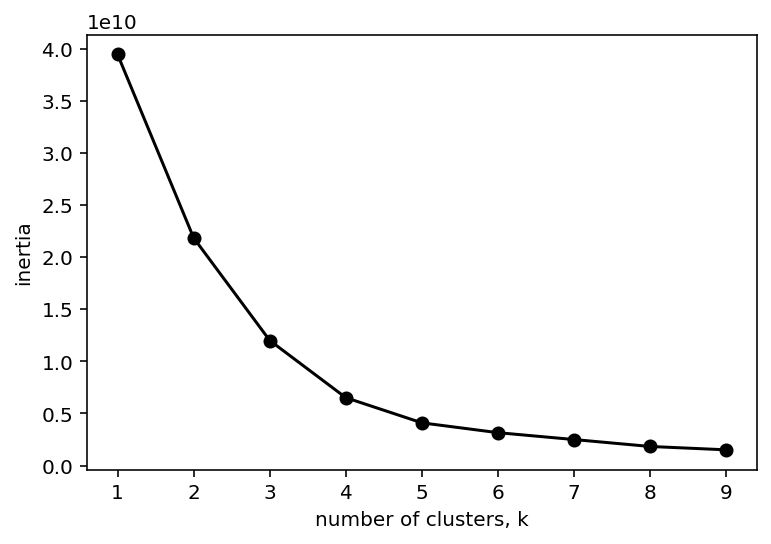

In [56]:
#elbow plot for resampled data
elbow_plot(res_reduced_data,3)

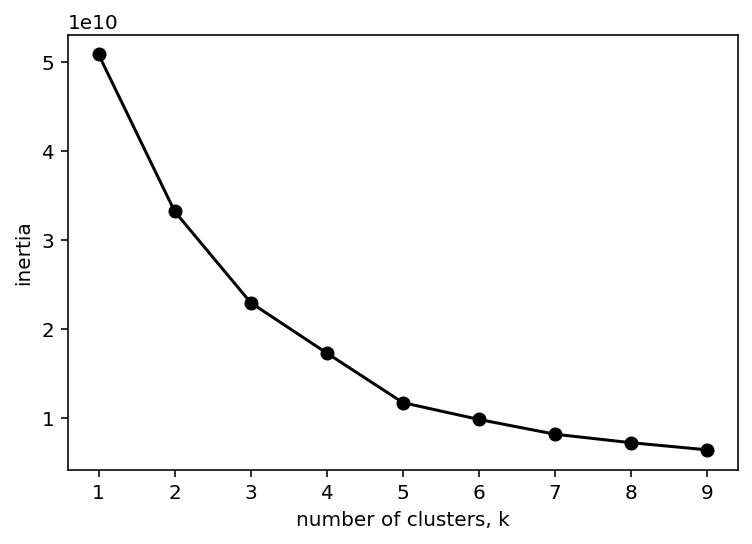

In [57]:
#resampled data with 4 components
elbow_plot(res_reduced_data,4)

Here, we see something that is more consistent with our 3D plots. The data before over-sampling can separate about 3 individual clusters. However, the resampled data while it shows 2 distinct clusters at some angles, it starts looking a lot more jumbled up when the image is rotated, not to mention that the clusters provided by the resampled data are not uniformed at all. 

This can be due to the fact that when using over-sampling techniques, it is import to make sure that the new synthesized data examples are realistic. In the case of accident reports, it is very hard to explain by what means one would determine whether or not a specific combinations of features would be realistic or not. 

It can also be said that the data before over-sampling is trying to find patterns in the data that don't necessarily exist because it doesn't have enough information to accurately learn from the data. In this case, it could be that the resampled data found the right amount of clusters and they aren't necessarily related to the Injury Type. 

Let's try some of our hypotheses by plotting the clusters produced by KMeans and the clusters we saw by Injury Type.

####Getting Clusters for data before over-sampling

using the first two components 

In [58]:
km_model = KMeans(n_clusters=3)

predicted = km_model.fit_predict(reduced_data.iloc[:,:2])

In [59]:
#adding cluster assigment to data frame 
reduced_data['Cluster'] = predicted

In [60]:
#getting references to each cluster
c1 = reduced_data[reduced_data['Cluster']==0]
c2 = reduced_data[reduced_data['Cluster']==1]
c3 = reduced_data[reduced_data['Cluster']==2]

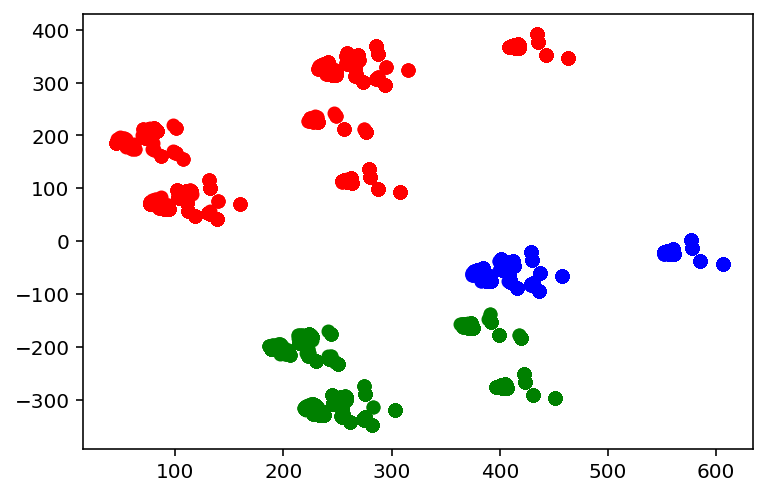

In [61]:
#plotting clusters
plt.scatter(c1[0],c1[1],color='blue')
plt.scatter(c2[0],c2[1],color='red')
plt.scatter(c3[0],c3[1],color='green')

In [62]:
#getting reference to data by Injury Types combining incapaciting and fatal as we saw in the visual
i1 = reduced_data[data_to_reduce['Injury Type']==injury_types[0]]
i2 = reduced_data[data_to_reduce['Injury Type']==injury_types[1]]
i3 = reduced_data[(data_to_reduce['Injury Type']==injury_types[2])|(data_to_reduce['Injury Type']==injury_types[3])]

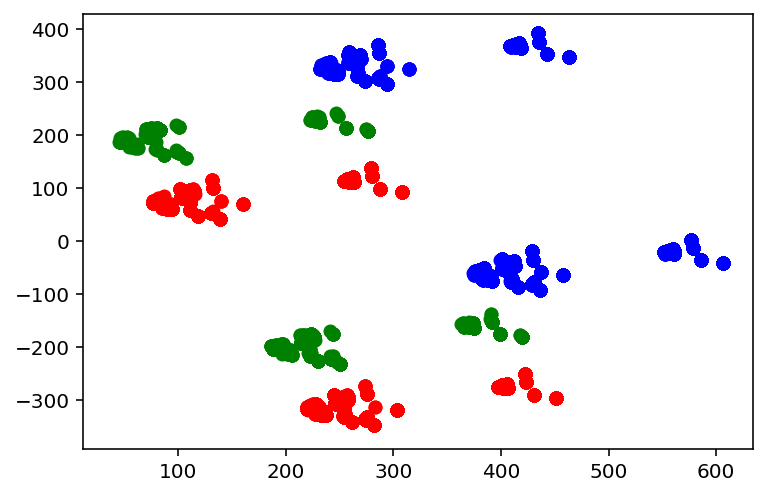

In [63]:
#plotting by Injury Type
plt.scatter(i1[0],i1[1],color='blue')
plt.scatter(i2[0],i2[1],color='red')
plt.scatter(i3[0],i3[1],color='green')

The clusters don't really match. This is a sign that K-means is not clustering bases on Injury Type but maybe by some other attribute hidden in the data. 

####Clusters resampled data

Using the first 3 components and 4 clusters as given by the elbow 

In [64]:
km_model = KMeans(n_clusters=4)

res_predicted = km_model.fit_predict(res_reduced_data.iloc[:,:3])

In [65]:
#adding cluster assigment to data frame 
res_reduced_data['Cluster'] = res_predicted

In [66]:
#getting references to each cluster
rc1 = res_reduced_data[res_reduced_data['Cluster']==0]
rc2 = res_reduced_data[res_reduced_data['Cluster']==1]
rc3 = res_reduced_data[res_reduced_data['Cluster']==2]
rc4 = res_reduced_data[res_reduced_data['Cluster']==3]

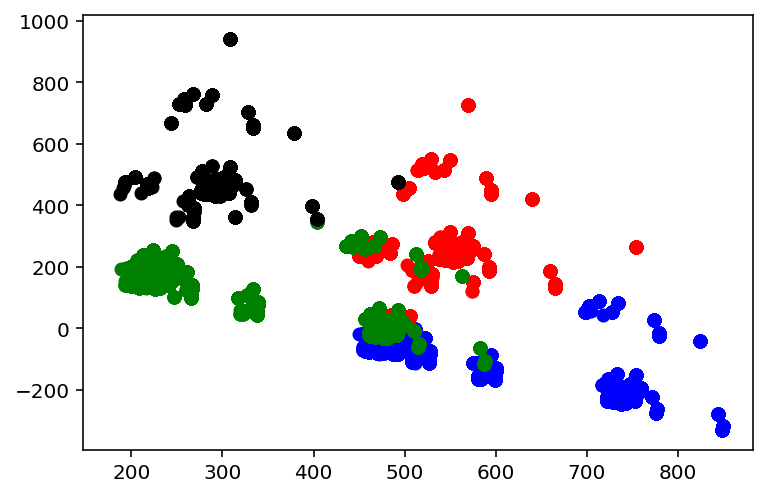

In [67]:
#plotting clusters
plt.scatter(rc1[0],rc1[1],color='blue')
plt.scatter(rc2[0],rc2[1],color='red')
plt.scatter(rc3[0],rc3[1],color='green')
plt.scatter(rc4[0],rc4[1],color='black')

In [68]:
#getting reference to data by Injury Types combining incapaciting and fatal as we saw in the visual
ri1 = res_reduced_data[res_data['Injury Type']==injury_types[0]]
ri2 = res_reduced_data[res_data['Injury Type']==injury_types[1]]
ri3 = res_reduced_data[(res_data['Injury Type']==injury_types[2])]
ri4 = res_reduced_data[(res_data['Injury Type']==injury_types[3])]

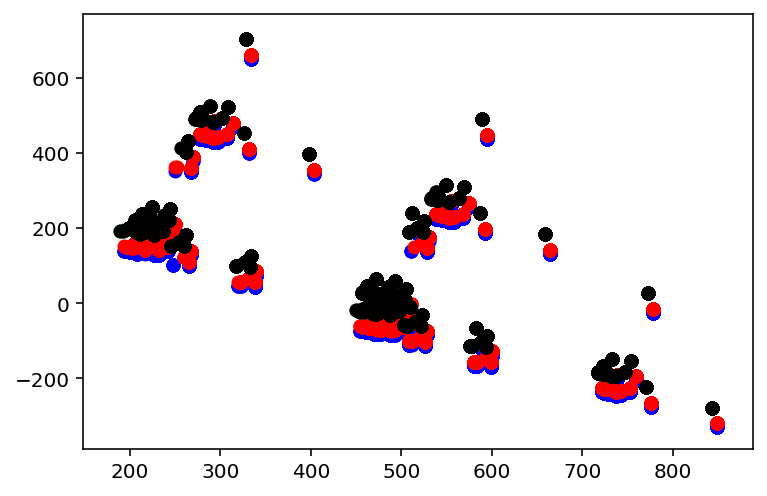

In [69]:
#plotting by Injury Type
plt.scatter(ri1[0],ri1[1],color='blue')
plt.scatter(ri2[0],ri2[1],color='red')
plt.scatter(ri3[0],ri3[1],color='green')
plt.scatter(ri3[0],ri3[1],color='black')

Once again, these clusters don't seem to have a direct relationship with Injury type attribute. 

We can assume that the KMeans algorithms is not using the same metrics to measure closeness or similarity between the examples as we our idea of space that we infer from visually inspecting the data. It could also be that some of the features from the original data don't make sense to use in trying to uncover any significant pattern in the data. We need to see exactly how these features are correlated to each other. 

If KMeans is finding some hidden patterns in the data, even if we don't know what it is, we can try to use some predictive models to see if the original features can be used to predict the clusters that were found by KMeans. 

###Descriptive Statistics

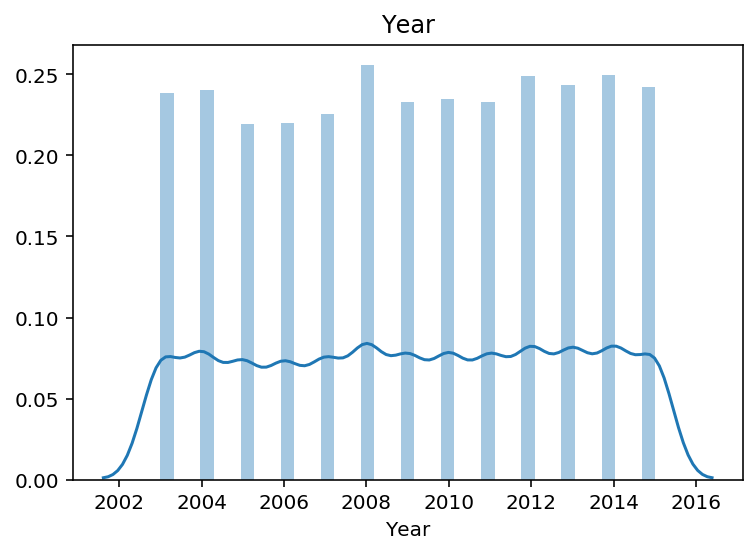

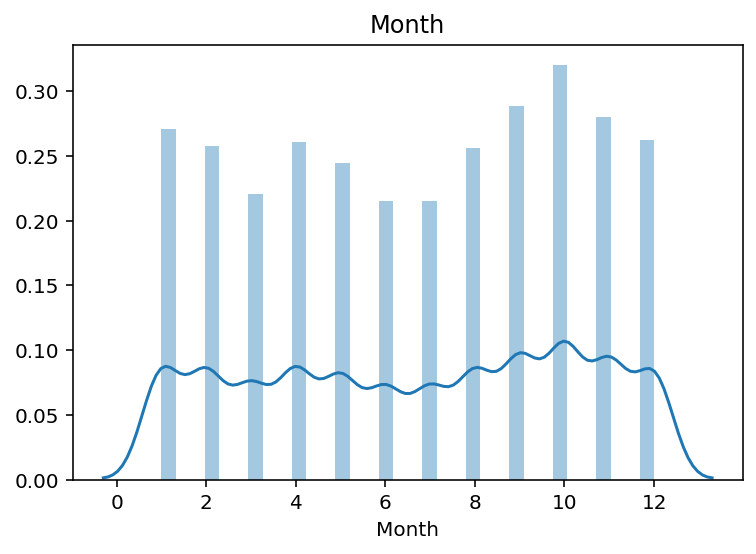

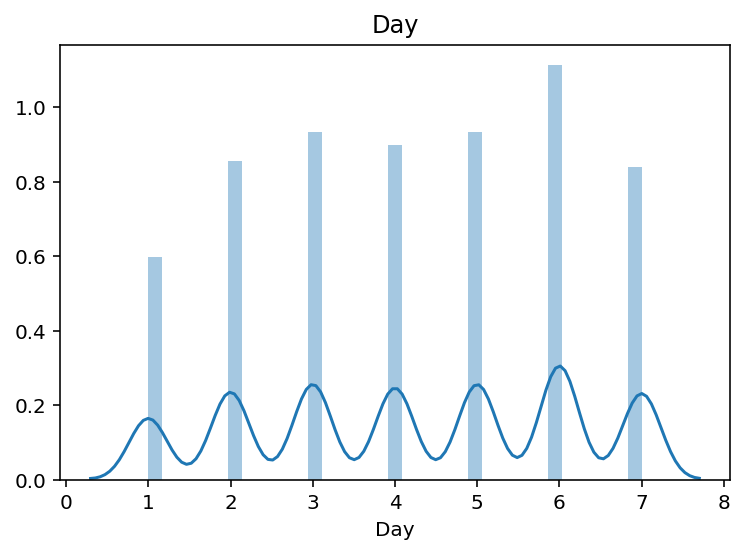

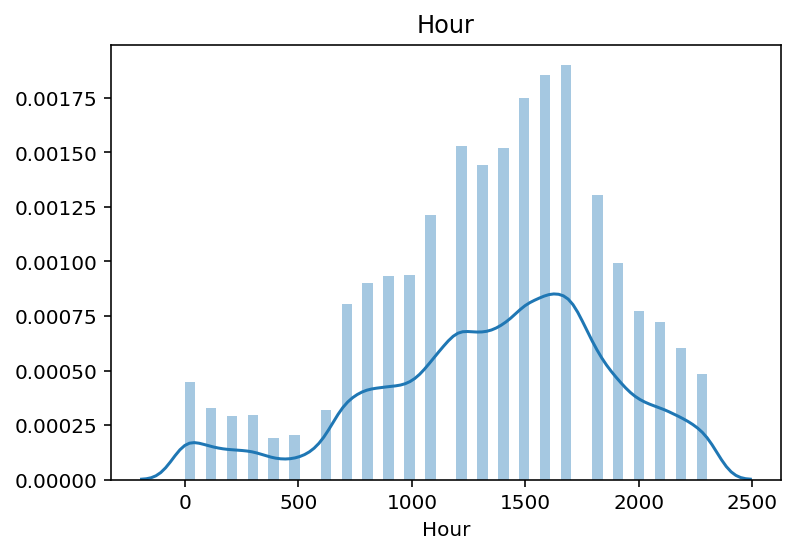

In [70]:
# Histograms
for i in data[['Year','Month','Day','Hour']].columns:
  sns.distplot(data[i])
  plt.title(i)
  plt.show()

from this we see that most of the time based features, except for time are evenly distributed in the data. So we can assume that they are not really going to have any predictive value for other attributes in the data. 

We'll also remove any location information from the data since we are trying to predict the injury type. 

But first let's see how these features are correlated with each other. 

Firts we have to transform our data

###Encoding Categorical Values

We'll use the original data first 

In [71]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
c_data = data.copy()

In [72]:
for i in c_data.drop(['Latitude','Longitude','Month','Day'],axis='columns').columns:
  c_data[i] = le.fit_transform(c_data[i])

In [73]:
print(c_data)

       Year  Month  Day  Weekend?  Hour  Collision Type  Injury Type  \
0        12      1    5         0     0               1            2   
1        12      1    6         0    15               1            2   
2        12      1    6         1    23               1            3   
3        12      1    7         1     9               1            3   
4        12      1    7         1    11               1            2   
...     ...    ...  ...       ...   ...             ...          ...   
53343     0     11    3         0    13               0            2   
53344     0      4    7         1    20               0            2   
53345     0      5    7         1    15               0            3   
53346     0     11    3         0    23               0            2   
53347     0     12    7         1    17               0            3   

       Primary Factor   Latitude  Longitude  
0                  27  39.159207 -86.525874  
1                  11  39.161440 -86.534848

In [74]:
print(c_data.corr())

                    Year     Month       Day  Weekend?      Hour  \
Year            1.000000 -0.012366 -0.005288 -0.000057 -0.018569   
Month          -0.012366  1.000000 -0.008475  0.002953  0.010692   
Day            -0.005288 -0.008475  1.000000  0.222196  0.007928   
Weekend?       -0.000057  0.002953  0.222196  1.000000 -0.022573   
Hour           -0.018569  0.010692  0.007928 -0.022573  1.000000   
Collision Type  0.029998  0.014464 -0.003042 -0.033826  0.074926   
Injury Type    -0.105997  0.004899 -0.001053 -0.009324  0.020465   
Primary Factor  0.067361 -0.033295  0.001551  0.038130 -0.050483   
Latitude        0.000590  0.004338  0.003296 -0.000218  0.000170   
Longitude       0.004765  0.003072 -0.005756 -0.001046  0.000785   

                Collision Type  Injury Type  Primary Factor  Latitude  \
Year                  0.029998    -0.105997        0.067361  0.000590   
Month                 0.014464     0.004899       -0.033295  0.004338   
Day                  -0.003042  

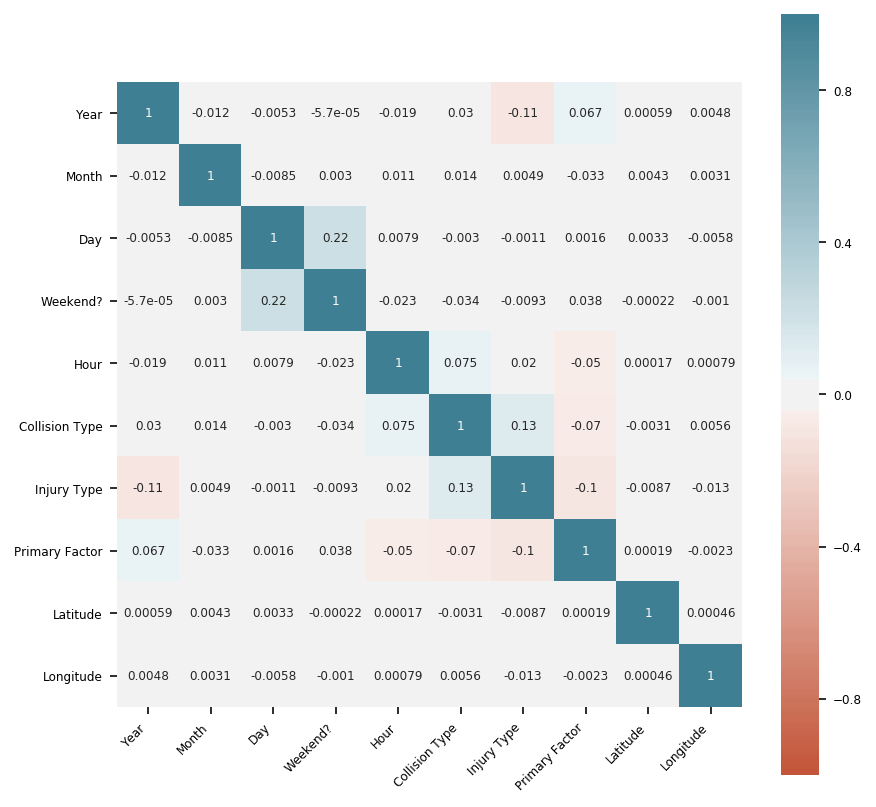

In [75]:
#HEATMAP
cor = c_data.corr()

plt.figure(figsize = (7,7))
plt.rcParams.update({'font.size': 6})

ax = sns.heatmap(
    cor,
    annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Since the correlations are low, we'll use a threshold of .1 to select which features are correlated. Surprisingly year is correlated with Injury type so we'll trust the data and keep it, along with Collision type and Primary factor with the data. 

####chi-squared function


In [76]:
from scipy.stats import chi2_contingency

def chi_squared(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    print(c1,' and ',c2)
    return(chi2_contingency(ctsum.fillna(0))[:3])# returns chi-squared, P-value, and degree of freedom



####chi squared tests

In [77]:
for i in data.drop(['Injury Type','Latitude','Longitude'],axis='columns').columns:
    print(chi_squared(data,'Injury Type',i))

Injury Type  and  Year
(1541.642847339027, 5.933722040734971e-301, 36)
Injury Type  and  Month
(213.7267279344056, 2.4478307189874788e-28, 33)
Injury Type  and  Day
(38.856499726796315, 0.0029787857222501545, 18)
Injury Type  and  Weekend?
(18.42244613395222, 0.0003598569977908674, 3)
Injury Type  and  Hour
(186.2541941370643, 1.014819942886477e-12, 69)
Injury Type  and  Collision Type
(5898.8836595867315, 0.0, 18)
Injury Type  and  Primary Factor
(4109.672300759151, 0.0, 162)


We see that those chi-squared tests among those variables are higher as well. So we will choose the three variables Year, Collision Type, and Primary Factory for our features, using Injury Type as the target variable. 

####Feature Selection 

Let's use SKLearn built-in feature selection to try to see if the analysis matches ours. 

###Transforming Data for Training

In [78]:
#Checking distinct primary factors
primary_factors = data['Primary Factor'].unique()
primary_factors

array(['OTHER (DRIVER) - EXPLAIN IN NARRATIVE', 'FOLLOWING TOO CLOSELY',
       'DISREGARD SIGNAL/REG SIGN', 'FAILURE TO YIELD RIGHT OF WAY',
       'DRIVER DISTRACTED - EXPLAIN IN NARRATIVE',
       'ENGINE FAILURE OR DEFECTIVE', 'RAN OFF ROAD RIGHT',
       'UNSAFE BACKING', 'ROADWAY SURFACE CONDITION',
       'SPEED TOO FAST FOR WEATHER CONDITIONS',
       'ANIMAL/OBJECT IN ROADWAY', 'PEDESTRIAN ACTION',
       'IMPROPER TURNING', 'UNSAFE LANE MOVEMENT', 'LEFT OF CENTER',
       'IMPROPER LANE USAGE', 'OVERCORRECTING/OVERSTEERING',
       'BRAKE FAILURE OR DEFECTIVE', 'UNSAFE SPEED',
       'DRIVER ASLEEP OR FATIGUED', 'VIEW OBSTRUCTED', 'DRIVER ILLNESS',
       'IMPROPER PASSING', 'OTHER (VEHICLE) - EXPLAIN IN NARRATIVE',
       'OTHER (ENVIRONMENTAL) - EXPLAIN IN NARR', 'WRONG WAY ON ONE WAY',
       'ACCELERATOR FAILURE OR DEFECTIVE', 'INSECURE/LEAKY LOAD',
       'CELL PHONE USAGE', 'TIRE FAILURE OR DEFECTIVE',
       'OTHER TELEMATICS IN USE', 'OTHER LIGHTS DEFECTIVE',
       '

In [79]:
print(len(primary_factors))

55


We'll one-hot encode primary factors since the amount of disctint values seem to repeat in the data.

We'll also one-hot encode the collision type.

We'll label encode the injury type by level of severity, since we might want to use it as a target variable.




In [80]:
#one-hot encoding primary factors 
enc_primary_factor = pd.get_dummies(data['Primary Factor'],drop_first = True)
#one-hot encoding collision types 
enc_collision_type = pd.get_dummies(data['Collision Type']).drop('Bus',axis = 'columns')
#concatinating the two 
transformed_data = pd.concat([enc_collision_type,enc_primary_factor],axis = 'columns')

#merge Injury type as target variable
transformed_data = pd.concat([data['Year'],transformed_data,data['Injury Type']],axis = 'columns')

#c Injury Type Label Encoding in order of severity 
transformed_data['Injury Type'] = transformed_data['Injury Type'].map({'No injury/unknown':0,'Non-incapacitating':1,'Incapacitating':2,'Fatal':3})

#d making injury types numeric
#transformed_data['Injury Type']=pd.to_numeric(ndf['Injury Type'])

#engineering new feature that turns four class target class into a two class target
#ndf['Severe Injury'] = ndf['Injury Type'].map({0:0,1:0,2:1,3:1})

In [81]:
print(transformed_data)

       Year  1-Car  2-Car  3+ Cars  Cyclist  Moped/Motorcycle  Pedestrian  \
0      2015      0      1        0        0                 0           0   
1      2015      0      1        0        0                 0           0   
2      2015      0      1        0        0                 0           0   
3      2015      0      1        0        0                 0           0   
4      2015      0      1        0        0                 0           0   
...     ...    ...    ...      ...      ...               ...         ...   
53343  2003      1      0        0        0                 0           0   
53344  2003      1      0        0        0                 0           0   
53345  2003      1      0        0        0                 0           0   
53346  2003      1      0        0        0                 0           0   
53347  2003      1      0        0        0                 0           0   

       ALCOHOLIC BEVERAGES  ANIMAL/OBJECT IN ROADWAY  \
0                  

now we can move on to some prediction 

#Prediction

##Model Selection

In [82]:
def try_model(model, X, y):
  #splitting train and test data
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2) 

  # Training  KNN Model
  m = model
  m.fit(X_train, y_train)
 
  print ("Cross_Validation_Mean_Score:""\n",cross_val_score(m,X_train,y_train,cv=5).mean())
  print()
  print (" Accuracy:" "\n",metrics.accuracy_score(y_test, m.predict(X_test)))
  print()
  print("Confusion Matrix:" "\n",metrics.confusion_matrix(y_test, m.predict(X_test)))
  print()
  print("Classification_Report:" "\n", metrics.classification_report(y_test, m.predict(X_test))) 
  print()


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

In [84]:
rf_model = RandomForestClassifier(n_estimators=10)
knn_model = KNeighborsClassifier()
log_model = LogisticRegression()

###Partitioning data

In [85]:
#partitioning data
X,y = transformed_data.drop('Injury Type',axis = 'columns'),transformed_data['Injury Type']

###Cross Val Scores 

Using transfomed data 

In [86]:
#Random Forest
try_model(rf_model,X,y)

Cross_Validation_Mean_Score:
 0.7793083119932255

 Accuracy:
 0.7781844802342606

Confusion Matrix:
 [[7107  143   10    1]
 [1727  326   22    0]
 [ 148   55    8    0]
 [  12    3    0    0]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87      7261
           1       0.62      0.16      0.25      2075
           2       0.20      0.04      0.06       211
           3       0.00      0.00      0.00        15

    accuracy                           0.78      9562
   macro avg       0.40      0.29      0.30      9562
weighted avg       0.74      0.78      0.72      9562




In [87]:
#KNN
try_model(knn_model,X,y)

Cross_Validation_Mean_Score:
 0.752615221688824

 Accuracy:
 0.7569546120058566

Confusion Matrix:
 [[6749  450   15    0]
 [1629  477    9    0]
 [ 131   65   12    0]
 [  14   11    0    0]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86      7214
           1       0.48      0.23      0.31      2115
           2       0.33      0.06      0.10       208
           3       0.00      0.00      0.00        25

    accuracy                           0.76      9562
   macro avg       0.40      0.30      0.32      9562
weighted avg       0.71      0.76      0.72      9562




In [88]:
#Logistic Regression
try_model(log_model,X,y)

Cross_Validation_Mean_Score:
 0.781583609489242

 Accuracy:
 0.7838318343442794

Confusion Matrix:
 [[7203   69    0    0]
 [1765  292    0    0]
 [ 154   54    0    0]
 [  16    9    0    0]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88      7272
           1       0.69      0.14      0.24      2057
           2       0.00      0.00      0.00       208
           3       0.00      0.00      0.00        25

    accuracy                           0.78      9562
   macro avg       0.37      0.28      0.28      9562
weighted avg       0.75      0.78      0.72      9562




Let's see if the reduced data can be used to determine the injury type. But we have to reduce it without the target variable. And we'll use the resampled data since it is more evenly spread out for the target class. 

In [89]:
#reducing data
reduced_train_data = pd.DataFrame(mca.fit_transform(res_data.drop('Injury Type',axis = 1)))

In [90]:
#percentage of data representedd
pd.DataFrame(mca.explained_inertia_[:8]).sum()

0    0.850886
dtype: float64

We see that the first 8 components hold about 85 percent of the data so we'll use those. 

In [91]:
#new X and y
X2 = reduced_train_data.iloc[:,:8]
y2 = res_data['Injury Type']

In [92]:
#Random Forest
try_model(rf_model,X2,y2)

Cross_Validation_Mean_Score:
 0.8235001159774467

 Accuracy:
 0.8395774267584717

Confusion Matrix:
 [[7412   22   25   33]
 [  71 7086  152  182]
 [ 168  450 5062 1611]
 [ 137  368 1534 5315]]

Classification_Report:
                     precision    recall  f1-score   support

             Fatal       0.95      0.99      0.97      7492
    Incapacitating       0.89      0.95      0.92      7491
 No injury/unknown       0.75      0.69      0.72      7291
Non-incapacitating       0.74      0.72      0.73      7354

          accuracy                           0.84     29628
         macro avg       0.83      0.84      0.84     29628
      weighted avg       0.84      0.84      0.84     29628




In [93]:
#KNN
try_model(knn_model,X2,y2)

Cross_Validation_Mean_Score:
 0.7912580931103566

 Accuracy:
 0.8052517888483867

Confusion Matrix:
 [[7487   44   21   42]
 [ 131 6947  152  194]
 [ 226  592 4334 2001]
 [ 289  614 1464 5090]]

Classification_Report:
                     precision    recall  f1-score   support

             Fatal       0.92      0.99      0.95      7594
    Incapacitating       0.85      0.94      0.89      7424
 No injury/unknown       0.73      0.61      0.66      7153
Non-incapacitating       0.69      0.68      0.69      7457

          accuracy                           0.81     29628
         macro avg       0.80      0.80      0.80     29628
      weighted avg       0.80      0.81      0.80     29628




In [94]:
#Logistic Regression 
try_model(log_model,X2,y2)

Cross_Validation_Mean_Score:
 0.4957725591680388

 Accuracy:
 0.4886593762656946

Confusion Matrix:
 [[5560  911  825   66]
 [1966 3189  747 1562]
 [ 793 1393 3688 1448]
 [1023 2436 1980 2041]]

Classification_Report:
                     precision    recall  f1-score   support

             Fatal       0.60      0.76      0.67      7362
    Incapacitating       0.40      0.43      0.41      7464
 No injury/unknown       0.51      0.50      0.51      7322
Non-incapacitating       0.40      0.27      0.32      7480

          accuracy                           0.49     29628
         macro avg       0.48      0.49      0.48     29628
      weighted avg       0.48      0.49      0.48     29628




Using the reduced data, we see improvement in KNN and Random Forest but Logistic Regression's performance dropped significantly. 

We see that we can get some impovements in our models by using the reduced data rather than the selected features from the original data. But we can still try something else to improve the usefulness of our models. 

As of now the models are trying to predict four different classes of Injury Type, which are No Injury/Unknown, Non-Incapacitating, Incapacitating, and Fatal. We can observe the this attribute can be summerized into two classes, Non-Severe and Severe. 

We create a new attribute out of the Injury Type that only has a binary value and we'll use that as the new target value. 

In [95]:
transformed_data['Severe'] = transformed_data['Injury Type'].map({0:0,1:0,2:1,3:1})

In [96]:
#defining new X and y
X3,y3 = transformed_data.drop(['Injury Type','Severe'],axis = 1), transformed_data['Severe']

now we try our models using severe as the target variable

In [97]:
#Random Forest
try_model(rf_model,X3,y3)

Cross_Validation_Mean_Score:
 0.9749529187889913

 Accuracy:
 0.9759464547165865

Confusion Matrix:
 [[9327   15]
 [ 215    5]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9342
           1       0.25      0.02      0.04       220

    accuracy                           0.98      9562
   macro avg       0.61      0.51      0.51      9562
weighted avg       0.96      0.98      0.97      9562




In [98]:
#KNN
try_model(knn_model,X3,y3)

Cross_Validation_Mean_Score:
 0.9763647484356536

 Accuracy:
 0.9741685839782472

Confusion Matrix:
 [[9303   36]
 [ 211   12]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9339
           1       0.25      0.05      0.09       223

    accuracy                           0.97      9562
   macro avg       0.61      0.52      0.54      9562
weighted avg       0.96      0.97      0.97      9562




In [99]:
#Logistic Regression
try_model(log_model,X3,y3)

Cross_Validation_Mean_Score:
 0.9769661204078334

 Accuracy:
 0.9767830997699226

Confusion Matrix:
 [[9340    0]
 [ 222    0]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9340
           1       0.00      0.00      0.00       222

    accuracy                           0.98      9562
   macro avg       0.49      0.50      0.49      9562
weighted avg       0.95      0.98      0.97      9562




We see now that our models are able to predict the severity of the injury based on the selected features. Now we'll try it with the resampled reduced data to see if we can get even more improvement. 
X2 is the first 8 components of our resampled data. 

In [100]:
#mapping to reduced data. 
y4 = res_data['Injury Type'].map({'No injury/unknown':0,'Non-incapacitating':0,'Incapacitating':1,'Fatal':1})


In [101]:
#Random Forest
try_model(rf_model,X2,y4)

Cross_Validation_Mean_Score:
 0.9490760308635287

 Accuracy:
 0.9515998379910895

Confusion Matrix:
 [[13893   803]
 [  631 14301]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     14696
           1       0.95      0.96      0.95     14932

    accuracy                           0.95     29628
   macro avg       0.95      0.95      0.95     29628
weighted avg       0.95      0.95      0.95     29628




In [102]:
#KNN 
try_model(knn_model,X2,y4)

Cross_Validation_Mean_Score:
 0.9242426642235262

 Accuracy:
 0.9337451059808289

Confusion Matrix:
 [[13259  1439]
 [  524 14406]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     14698
           1       0.91      0.96      0.94     14930

    accuracy                           0.93     29628
   macro avg       0.94      0.93      0.93     29628
weighted avg       0.94      0.93      0.93     29628




In [103]:
#Logistic Regression
try_model(log_model,X2,y4)

Cross_Validation_Mean_Score:
 0.7459032779332719

 Accuracy:
 0.7461860402322128

Confusion Matrix:
 [[12580  2250]
 [ 5270  9528]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.70      0.85      0.77     14830
           1       0.81      0.64      0.72     14798

    accuracy                           0.75     29628
   macro avg       0.76      0.75      0.74     29628
weighted avg       0.76      0.75      0.74     29628




Once again we observe that logistic regression didn't perform as well as the other models on the reduced data. However, even the performance seems to have dropped when using the reduced data, the results can be trusted a little more because the reduced data came from the over-sampled data, which has a more even distribution for the target class. 

Let's try a neural network

In [104]:
from sklearn.neural_network import MLPClassifier

In [105]:
nn_model = MLPClassifier(activation='logistic', batch_size='auto',
                         early_stopping=True,
                         epsilon=1e-08, hidden_layer_sizes=(8,8,4,2),
                         learning_rate_init=0.001,
                         learning_rate = 'adaptive',
                         max_iter=200,random_state=2)

In [106]:
try_model(nn_model,X,y3)

Cross_Validation_Mean_Score:
 0.9765739430347932

 Accuracy:
 0.9783518092449278

Confusion Matrix:
 [[9355    0]
 [ 207    0]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9355
           1       0.00      0.00      0.00       207

    accuracy                           0.98      9562
   macro avg       0.49      0.50      0.49      9562
weighted avg       0.96      0.98      0.97      9562




In [107]:
try_model(nn_model,X2,y4)

Cross_Validation_Mean_Score:
 0.7430005545287159

 Accuracy:
 0.7436546510058053

Confusion Matrix:
 [[12094  2602]
 [ 4993  9939]]

Classification_Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76     14696
           1       0.79      0.67      0.72     14932

    accuracy                           0.74     29628
   macro avg       0.75      0.74      0.74     29628
weighted avg       0.75      0.74      0.74     29628




Here we see similar results for the selected features and the new target variable but the neural network, like logistic regression, performs worse when the components are used as features. 

#Final Plotting

Since our selected features seem to be able to predict the injury class with decent accuracy, we'll use them to plot, once again, and get a visual on the transformed data. 

In [108]:
new_data = data[['Year','Collision Type','Primary Factor','Injury Type']]

In [109]:
mca2 = prince.MCA(n_components = 3,
                 n_iter = 5,
                 copy = True,
                 check_input = True,
                 engine = 'auto',
                 random_state = 42)

In [110]:
new_data_components = mca2.fit_transform(transformed_data)

###2D

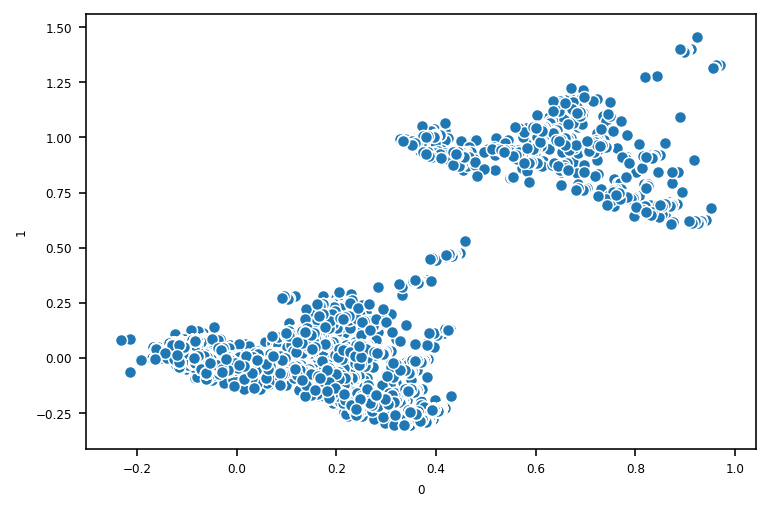

In [111]:
sns.scatterplot(new_data_components[0],new_data_components[1])

In [112]:
x,y = new_data_components[0],new_data_components[1]

Color Coding

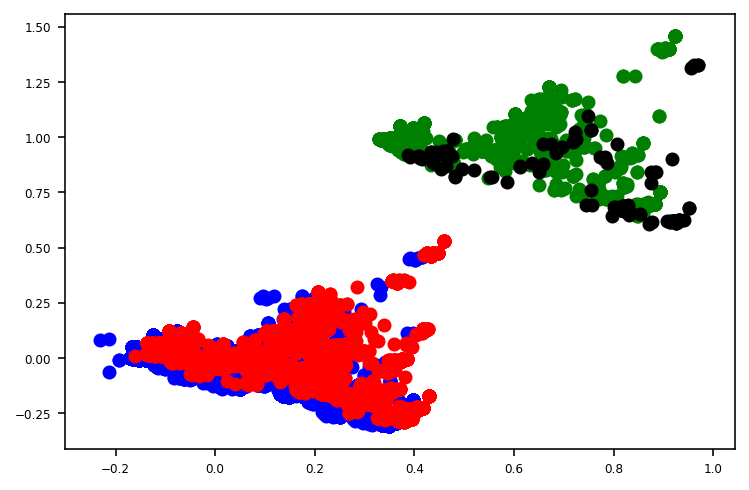

In [113]:
#testing clusters in plot
x1,y1 = x[data_to_reduce['Injury Type'] == injury_types[0]],y[data_to_reduce['Injury Type'] == injury_types[0]]
x2,y2 = x[data_to_reduce['Injury Type'] == injury_types[1]],y[data_to_reduce['Injury Type'] == injury_types[1]]
x3,y3 = x[data_to_reduce['Injury Type'] == injury_types[2]],y[data_to_reduce['Injury Type'] == injury_types[2]]
x4,y4 = x[data_to_reduce['Injury Type'] == injury_types[3]],y[data_to_reduce['Injury Type'] == injury_types[3]]

plt.scatter(x1,y1,color = 'blue')
plt.scatter(x2,y2,color = 'red')
plt.scatter(x3,y3,color ='green')
plt.scatter(x4,y4,color ='black')

We see that the data is being seperated in what we defined as Severe and Non-Severe

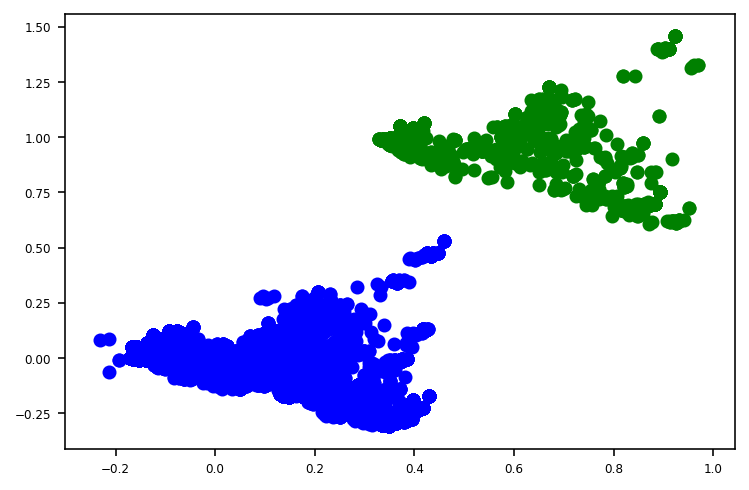

In [114]:
x1,y1 = x[data_to_reduce['Injury Type'] == injury_types[0]],y[data_to_reduce['Injury Type'] == injury_types[0]]
x2,y2 = x[data_to_reduce['Injury Type'] == injury_types[1]],y[data_to_reduce['Injury Type'] == injury_types[1]]
x3,y3 = x[data_to_reduce['Injury Type'] == injury_types[2]],y[data_to_reduce['Injury Type'] == injury_types[2]]
x4,y4 = x[data_to_reduce['Injury Type'] == injury_types[3]],y[data_to_reduce['Injury Type'] == injury_types[3]]

plt.scatter(x1,y1,color = 'blue')
plt.scatter(x2,y2,color = 'blue')
plt.scatter(x3,y3,color ='green')
plt.scatter(x4,y4,color ='green')

###3D

In [115]:
#defining z
z = new_data_components[2]

z1,z2,z3,z4 = z[data_to_reduce['Injury Type'] == injury_types[0]],z[data_to_reduce['Injury Type'] == injury_types[1]],z[data_to_reduce['Injury Type'] == injury_types[2]],z[data_to_reduce['Injury Type'] == injury_types[3]]


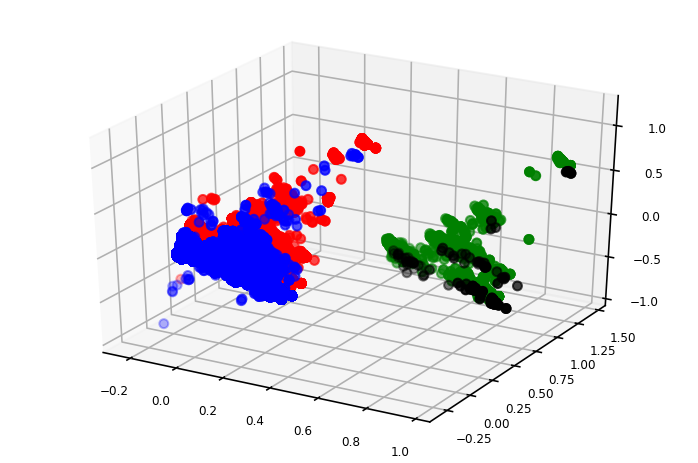

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1,y1,z1,c='blue')
ax.scatter(x2,y2,z2,c='red')
ax.scatter(x3,y3,z3,c='green')
ax.scatter(x4,y4,z4,c='black') 

Now with the two clusters color coded by the severe attribute. 

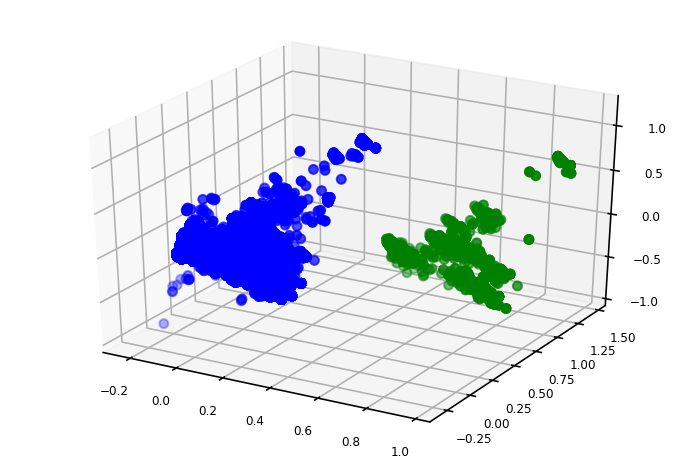

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1,y1,z1,c='blue')
ax.scatter(x2,y2,z2,c='blue')
ax.scatter(x3,y3,z3,c='green')
ax.scatter(x4,y4,z4,c='green')